In [1]:
trainingOHCA_fileName = "generatedPoints1_100000_subzone.csv"
candidateAED_fileName = "buildings_locations_subzone.csv"

In [2]:
import pandas as pd
import numpy as np
from haversine import haversine_vector, Unit
from haversine import haversine
from os import path
import scipy.sparse
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
from pulp import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt     
import seaborn as sns
from itertools import combinations
from sklearn import preprocessing, cluster
from sklearn.metrics import silhouette_score
import scipy
import scipy.cluster
from matplotlib import colors as mcolors
from skimage.io import imread
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
import time

In [3]:
def PCM2(OHCA_Cluster,AED_Cluster,pij,P):
    J = OHCA_Cluster.index.values.tolist()
    I = AED_Cluster.index.values.tolist()
    
    #Decision Variables + Maximization
    
    prob = LpProblem("PCM",LpMaximize)
    w = LpVariable.dicts("w",(I,J),0,1,cat = "Integer")
    y = LpVariable.dicts("y",I,0,1,cat="Integer")
    
    #objective
    
    prob += lpSum([pij[j][i]*w[i][j] for i in I for j in J if pij[j][i] > 0])
    
    #constraints
    
    for j in J:
        for i in I:
            if (pij[j][i] > 0):
                prob += w[i][j] <= y[i]
    for j in J:
        prob += lpSum([w[i][j] for i in I if pij[j][i] > 0]) <= 1
    
    prob += lpSum([y[i] for i in I]) <= P
    prob.solve(GUROBI(msg=0))
    y_soln = np.array([y[i].varValue for i in I])
    print("Coverage is ",value(prob.objective))
    AED_Chosen = pd.concat([AED_Cluster,pd.DataFrame(y_soln,columns=['y'])],axis=1)
    AED_Chosen = AED_Chosen[AED_Chosen['y'] == 1]
    AED_Chosen = AED_Chosen.drop(columns=['y'])
    return(AED_Chosen)

In [4]:
def kmeans_OHCA_AED(OHCA,AED,k=2): #k is the number of clusters chosen
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(OHCA)
    
    OHCA_Cluster_All = pd.concat([OHCA,pd.DataFrame(kmeans.labels_,columns = ["cluster"])],axis=1)
    AED_lable = kmeans.predict(AED)
#     print(len(AED_lable))
    AED_Cluster_All = pd.concat([AED, pd.DataFrame(AED_lable,columns = ["cluster"])], axis=1)

    return OHCA_Cluster_All, AED_Cluster_All

In [5]:
def coveragefunction(OHCA_Cluster,AED_Cluster):
    pij = haversine_vector(list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA)), list(zip(AED_Cluster.LatAED, AED_Cluster.LongAED)), Unit.METERS, comb=True).T
    pij = [[1 if p <= 20 else p for p in s] for s in pij]
    pij = [[np.exp(-0.05*(p - 20)) if p > 20 and p <= 100 else p for p in s] for s in pij]
    pij = [[0 if p>100 else p for p in s] for s in pij]
    return(pij)

In [6]:
def haverDist(OHCA_Cluster,AED_Cluster):
    d = haversine_vector(list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA)), list(zip(AED_Cluster.LatAED, AED_Cluster.LongAED)), Unit.METERS, comb=True).T
    return(d)

In [7]:
#test_OHCA = pd.read_csv(testOHCA_fileName, names = ["LatOHCA", "LongOHCA"], header = None)
OHCA = pd.read_csv(trainingOHCA_fileName)
candidateAED = pd.read_csv(candidateAED_fileName)
# candidateAED.columns = ["LatAED","LongAED"]
P_count=OHCA['region'].value_counts()
print(len(P_count.values))
print(P_count.values.sum())
P_count

327
96228


300    1966
273    1960
179    1646
105    1435
141    1428
       ... 
153      18
69       16
323      14
4         2
259       1
Name: region, Length: 327, dtype: int64

In [8]:
P_count2=candidateAED['region'].value_counts()
print(P_count2)

141    7122
164    5056
249    3933
162    3695
150    3694
       ... 
211       1
280       1
258       1
272       1
221       1
Name: region, Length: 321, dtype: int64


In [9]:
# P_count.at[159]

In [10]:
for subzone in range(1,333):

    if subzone not in (7, 8, 9,159,174,231, 239,283, 284, 287,301, 304, 305, 317, 323):
#         p_subzone=int(P_count.at[subzone]*9800/96228)
        print(subzone, P_count2.at[subzone] )

1 6
2 179
3 100
4 167
5 78
6 3
10 604
11 38
12 83
13 8
14 263
15 113
16 45
17 313
18 45
19 27
20 75
21 58
22 162
23 747
24 60
25 70
26 88
27 68
28 2856
29 12
30 91
31 106
32 315
33 26
34 127
35 20
36 18
37 81
38 789
39 71
40 95
41 215
42 146
43 65
44 630
45 43
46 115
47 31
48 93
49 37
50 75
51 283
52 140
53 57
54 198
55 480
56 412
57 191
58 28
59 52
60 218
61 105
62 144
63 99
64 124
65 2531
66 142
67 10
68 1381
69 93
70 63
71 62
72 428
73 153
74 211
75 150
76 135
77 79
78 252
79 200
80 25
81 13
82 253
83 292
84 136
85 157
86 720
87 864
88 121
89 198
90 7
91 32
92 176
93 46
94 299
95 292
96 293
97 31
98 131
99 1510
100 2840
101 1138
102 386
103 878
104 48
105 1887
106 215
107 75
108 1609
109 391
110 1478
111 136
112 331
113 77
114 78
115 334
116 11
117 460
118 70
119 84
120 58
121 45
122 62
123 1618
124 113
125 233
126 89
127 436
128 885
129 242
130 129
131 1110
132 363
133 940
134 625
135 217
136 89
137 289
138 575
139 1047
140 53
141 7122
142 153
143 1884
144 2663
145 112
146 157
147 

In [11]:
# input: two clusters 
# output: All_AED_in_Cluster
def PCM_in_Cluster(OHCA1,candidateAED1,p_subzone,k=2):
    OHCA1_clusters, candidateAED1_clusters = kmeans_OHCA_AED(OHCA1, candidateAED1,k)
    All_AED_in_Cluster=pd.DataFrame(columns=['LatAED', 'LongAED']) 
    for i in range(k):
        OHCA20a = OHCA1_clusters[OHCA1_clusters['cluster']==i][["LatOHCA","LongOHCA"]].reset_index(drop=True)
        candidateAED20a = candidateAED1_clusters[candidateAED1_clusters['cluster']==i][["LatAED","LongAED"]].reset_index(drop=True)
        if len(OHCA20a)>0 and len(candidateAED20a)>0:
                prob_pij = coveragefunction(OHCA20a,candidateAED20a)
                sub_AED_df = PCM2(OHCA20a,candidateAED20a,prob_pij,int(p_subzone/k))
                All_AED_in_Cluster=All_AED_in_Cluster.append(sub_AED_df)
        else: pass
    return All_AED_in_Cluster

In [14]:
%%time

start_time = time.time()

ALL_AED= pd.DataFrame(columns=['LatAED', 'LongAED']) 
all_AED_num=9880
all_OHCA_num=97542

for subzone in range(1,333):

    if subzone not in (7, 8, 9,159,174,231, 239,259,283, 284, 287,301, 304, 305, 317, 323):

        p_subzone=int(P_count.at[subzone]*all_AED_num/all_OHCA_num)
        print(subzone, P_count.at[subzone], p_subzone )
        OHCA1=OHCA[OHCA['region']== subzone]
        OHCA1=OHCA1[['LatOHCA','LongOHCA']].reset_index(drop=True)
        candidateAED1 = candidateAED[candidateAED['region']==subzone].copy()
        candidateAED1 = candidateAED1[['LatAED','LongAED']].reset_index(drop=True)
        candidateAED1 = candidateAED1.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
        AED_sub =PCM_in_Cluster(OHCA1,candidateAED1,p_subzone,2)
        ALL_AED=ALL_AED.append(AED_sub)
print("--- %s seconds ---" % (time.time() - start_time))

1 219 22
Coverage is  0.3220001568928099
Coverage is  9.946482703137125
2 153 15
Coverage is  30.08557269566356
Coverage is  14.013546522485374
3 199 20
Coverage is  35.27246156705545
Coverage is  34.75679826243262
4 2 0
Coverage is  0.0
Coverage is  0.0
5 151 15
Coverage is  12.841875924994259
Coverage is  20.939467502094228
6 153 15
Coverage is  0.5546684803155186
Coverage is  1.1763718667528464
10 179 18
Coverage is  5.215799428063719
Coverage is  11.403070065947933
11 523 52
Coverage is  29.709890560565956
Coverage is  10.211715472692967
12 29 2
Coverage is  4.226446202100845
Coverage is  2.498237881006614
13 117 11
Coverage is  1.632581701994115
Coverage is  0.6842881748081879
14 507 51
Coverage is  23.23385368164367
Coverage is  50.54824572581099
15 186 18
Coverage is  22.25637954304261
Coverage is  27.704792601220642
16 46 4
Coverage is  6.024142764568281
Coverage is  7.659896375400656
17 217 21
Coverage is  34.40042175615826
Coverage is  20.138351310496464
18 102 10
Coverage is

Coverage is  2.4041914193227103
120 42 4
Coverage is  0.7757253703249474
Coverage is  2.147343970477757
121 25 2
Coverage is  0.059205069048542405
Coverage is  0.757567637514448
122 109 11
Coverage is  11.336097418626391
Coverage is  10.629231651745453
123 342 34
Coverage is  57.74745744227977
Coverage is  75.87745085479563
124 83 8
Coverage is  11.188479003940989
Coverage is  11.192256483792551
125 214 21
Coverage is  17.559644791769568
Coverage is  24.803427563378325
126 233 23
Coverage is  18.913642859316628
Coverage is  22.68670211330636
127 185 18
Coverage is  27.509393320119983
Coverage is  21.836468063138422
128 403 40
Coverage is  72.43328117298437
Coverage is  59.867559803233156
129 177 17
Coverage is  25.169444117381065
Coverage is  28.19868410950714
130 388 39
Coverage is  60.29836758499706
Coverage is  60.49732323693952
131 230 23
Coverage is  30.80745839568956
Coverage is  27.919077708026276
132 71 7
Coverage is  6.761131098846291
Coverage is  5.795996150735689
133 346 35


Coverage is  100.81676348426222
Coverage is  113.65630124084686
237 103 10
Coverage is  1.3276438337835719
Coverage is  6.046329970456261
238 145 14
Coverage is  16.36547657108138
Coverage is  17.742410800971975
240 206 20
Coverage is  23.276638478108133
Coverage is  28.255300053631828
241 209 21
Coverage is  23.70596196714461
Coverage is  18.446508391786438
242 239 24
Coverage is  32.222011300428164
Coverage is  30.41145054250018
243 708 71
Coverage is  103.77330462070593
Coverage is  128.41250771221095
244 306 30
Coverage is  34.38861842778856
Coverage is  41.02468853796503
245 290 29
Coverage is  9.403804286972274
Coverage is  38.625248804634325
246 192 19
Coverage is  26.040264192436936
Coverage is  25.973519816356248
247 196 19
Coverage is  30.62276624907792
Coverage is  25.824613963429446
248 179 18
Coverage is  26.64456530607372
Coverage is  23.277264870958515
249 664 67
Coverage is  100.87350075852244
Coverage is  120.87700120319194
250 400 40
Coverage is  69.87421203801291
Cov

In [ ]:
# --- 531.563517332077 seconds ---
# Wall time: 8min 51s


In [15]:
print('The overall PCM AED result including all subzone is in this dataframe, you can use it to further calculate metrics : ')
ALL_AED.to_csv('PCM-MultiArea-KMeans-AED-Solution.csv')
print(len(ALL_AED))
ALL_AED

The overall PCM AED result including all subzone is in this dataframe, you can use it to further calculate metrics : 
8441


LatAED     LongAED
0    1.283549  103.877910
0    1.293043  103.872465
1    1.293949  103.868070
2    1.292964  103.868401
3    1.294632  103.875841
..        ...         ...
216  1.353699  103.846523
221  1.354123  103.846168
234  1.354043  103.847050
244  1.353233  103.847712
51   1.277594  103.637965

[8441 rows x 2 columns]

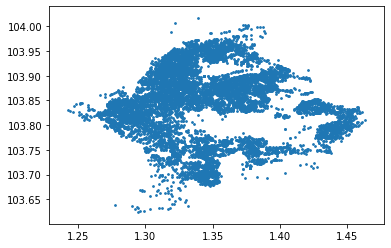

In [23]:
plt.scatter(
   ALL_AED['LatAED'], 
   ALL_AED['LongAED'],s=3
)

In [16]:
def totalCoverage(ohca_df, aed_df, MAX_DIST_METERS = 100):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000
    
    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 100, 'isCovered'] = 'covered'
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] > 100,'isCovered'] = 'uncovered'
    # each OHCA having an AED within 100m has isCovered = 'covered', otherwise 'uncovered'
    #print(cp_ohca)
    
    
    within_100m  = sum(cp_ohca['isCovered'] == 'covered')
    outside_100m = len(cp_ohca) - within_100m
    total_coverage_within_100m = within_100m / (within_100m + outside_100m)
    print("total coverage = ", total_coverage_within_100m)
    
    return total_coverage_within_100m

def partial_coverage(ohca_df, aed_df, ALPHA = 0.05):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 20,'p_ij_coverage'] = 1.0
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] >= 100,'p_ij_coverage'] = 0.0
    cp_ohca.loc[(cp_ohca['dist_nearest_AED'] < 100) & (cp_ohca['dist_nearest_AED'] > 20),
                'p_ij_coverage'] = np.exp(- ALPHA * (cp_ohca['dist_nearest_AED'] - 20))
    # p_ij of each OHCA calulated
    # print(cp_ohca)
    
    return cp_ohca['p_ij_coverage'].mean()

def expectedsurvival(OHCA,AED):
    prob = 0
    for i in range(len(OHCA)):
        survival = haversine_vector((OHCA.LatOHCA[i], OHCA.LongOHCA[i]), list(zip(AED.LatAED, AED.LongAED)), Unit.METERS, comb=True).T[0]
        survival = survival/(6.15*1000/60)*2
        survival = [p if np.isnan(p) == False else 0 for p in survival]
        survival = [1 if p<=1 and p != 0 else p for p in survival]
        survival = [p if p<20 else 0 for p in survival]
        survival = [p if p==0 or p == 1 else ((p**-0.584)*0.549) for p in survival]
        prob += max(survival)
    expectedSurvival = prob/len(OHCA)
    return(expectedSurvival)

In [18]:
def average_distance(ohca_df, aed_df):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    
    return cp_ohca['dist_nearest_AED'].mean()

In [17]:
AED_Chosen_All_PCM= ALL_AED.reset_index(drop=True)
#total coverage 
PCM_TC = totalCoverage(OHCA,AED_Chosen_All_PCM,100)
print("PCM total coverage is : ", PCM_TC)
#partial coverage
PCM_PC = partial_coverage(OHCA,AED_Chosen_All_PCM)
print("PCM partial coverage is : ", PCM_PC)
#expected survival
PCM_ES = expectedsurvival(OHCA,AED_Chosen_All_PCM)
print("PCM expected survival is : ", PCM_ES)


total coverage =  0.5683376979673276
PCM total coverage is :  0.5683376979673276
PCM partial coverage is :  0.22227496032752575
PCM expected survival is :  0.5283094707137722


In [19]:
#average distance to nearest AED
PCM_AD = average_distance(OHCA, AED_Chosen_All_PCM)
print("PCM average distance is : ", PCM_AD)

PCM average distance is :  153.93730101540984
